<img src="http://vision.skills.network/logo-light.png" width="400" alt="CV Studio logo"  />


<h2>Transfer Learning with Convolutional Neural Networks For Classification with PyTorch and   <a href="https://vision.skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01"> Computer Vision Learning 
Studio
 (CV Studio)</a></h2> <p><b> V 0.2</b></p>
<h4>Project: Final_project_stop_signs</h4>
<h4>Training Run: traffic-stop-new-train</h4>


Estimated time needed: **40** minutes


In this lab, you will train a deep neural network for  image classification using <a href="https://cs231n.github.io/transfer-learning/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01">transfer learning</a>, the image dataset will automatically be download from your <a href="https://vision.skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01">CV Studio</a> account. Experiment with different hyperparameters.


## Objectives


In this lab you will train a state of the art image classifier using and <a href="https://vision.skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01">CV Studio</a>, CV Studio is a fast, easy and collaborative open source image annotation tool for teams and individuals. In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset in the lab, then use this Network to train your model. We will use the Convolutional Network as a feature generator, only training the output layer.  In general, 100-200 images will give you a good starting point, and it only takes about half an hour.  Usually, the more images you add, the better your results, but it takes longer and the rate of improvement will decrease.


-   Import Libraries and Define Auxiliary Functions
-   Create Dataset Object
-   Load Model and Train


* * *


## Import Libraries and Define Auxiliary Functions


In [1]:
#! conda install -c pytorch torchvision
#! pip install skillsnetwork tqdm
#!pip install  skillsnetwork

Libraries for OS and Cloud


In [7]:
import os
import uuid
import shutil
import json
from botocore.client import Config
import ibm_boto3
import copy
from datetime import datetime
from skillsnetwork import cvstudio 

Libraries for Data Processing and Visualization


In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time 

Deep Learning Libraries


In [9]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

Plot train cost and validation accuracy:


In [10]:
def plot_stuff(COST,ACC):    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

Plot the transformed image:


In [11]:
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp .permute(1, 2, 0).numpy() 
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()

Compare the prediction and actual value:


In [12]:
def result(model,x,y):
    #x,y=sample
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    
    if yhat.item()!=y:
        text="predicted: {} actual: {}".format(str(yhat.item()),y)
        print(text)

Define our device as the first visible cuda device if we have CUDA available:


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)


the device type is cpu


## Load Data


In this section we will preprocess our dataset by changing the shape of the image, converting to tensor and normalizing the image channels. These are the default preprocessing steps for image data. In addition, we will perform data augmentation on the training dataset. The preprocessing steps for the test dataset is the same, but W do not prform data augmentation on the test dataset. 


<code>
<p>mean = [0.485, 0.456, 0.406]</p>
<p>std = [0.229, 0.224, 0.225]</p>
<p>composed = transforms.Compose([transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),transforms.RandomRotation(degrees=5)
                               , transforms.ToTensor()
                               , transforms.Normalize(mean, std)])</p>
    </code>


Download the data:


In [14]:

# Get the Dataset
# Initialize the CV Studio Client
cvstudioClient = cvstudio.CVStudio()
# # Download All Images
cvstudioClient.downloadAll()

100%|██████████| 197/197 [00:32<00:00,  6.08it/s]


We need to get our training and validation dataset. 90% of the data will be used for training.


In [15]:
percentage_train=0.9
train_set=cvstudioClient.getDataset(train_test='train',percentage_train=percentage_train)
val_set=cvstudioClient.getDataset(train_test='test',percentage_train=percentage_train)

defult transform for pretrained model resnet18
this is the training set
defult transform for pretrained model resnet18
this is the test set


We can plot some of our dataset:


(224, 224, 3)


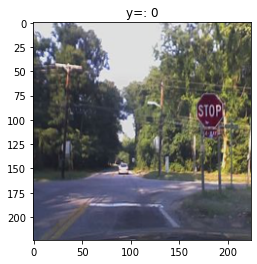

(224, 224, 3)


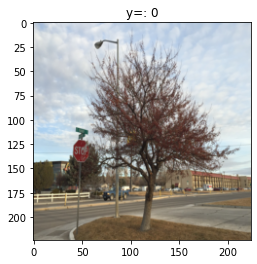

(224, 224, 3)


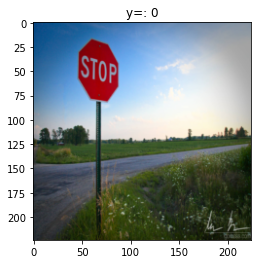

In [16]:
i=0

for x,y  in val_set:
    imshow_(x,"y=: {}".format(str(y.item())))
    i+=1
    if i==3:
        break

## Hyperparameters


Experiment with different hyperparameters:


<b>Epoch</b> indicates the number of passes of the entire training dataset, here we will set the number of epochs to 10:


In [17]:
n_epochs=10

<b>Batch size</b> is the number of training samples utilized in one iteration. If the batch size is equal to the total number of samples in the training set, then every epoch has one iteration. In Stochastic Gradient Descent, the batch size is set to one. A batch size of 32--512 data points seems like a good value, for more information check out the following <a href="https://arxiv.org/abs/1609.04836?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01">link</a>.


In [18]:
batch_size=32

 <b>Learning rate</b> is used in the training of neural networks. Learning rate is a hyperparameter with a small positive value, often in the range between 0.0 and 1.0.


In [19]:
lr=0.000001

<b>Momentum</b> is a term used in the gradient descent algorithm to improve training results:


In [20]:
momentum=0.9

If you set to <code>lr_scheduler=True</code>  for every epoch use a learning rate scheduler changes the range of the learning rate from a maximum or minimum value. The learning rate usually decays over time.


In [21]:
lr_scheduler=True
base_lr=0.001
max_lr=0.01

# Load Model and Train


This function will train the model 


In [22]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs,print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    #global:val_set
    n_test = len(val_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
        # Loop through the data in loader
    print("The first epoch should take several minutes")
    for epoch in tqdm(range(n_epochs)):
        
        loss_sublist = []
        # Loop through the data in loader

        for x, y in train_loader:
            x, y=x.to(device), y.to(device)
            model.train() 

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        print("epoch {} done".format(epoch) )

        scheduler.step()    
        loss_list.append(np.mean(loss_sublist))
        correct = 0


        for x_test, y_test in validation_loader:
            x_test, y_test=x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        
        if print_:
            print('learning rate',optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy)) 
    model.load_state_dict(best_model_wts)    
    return accuracy_list,loss_list, model

 Load the pre-trained model resnet18. Set the parameter pretrained to true.


In [23]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jupyterlab/.cache/torch/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

We will only train the last layer of the network set the parameter <code>requires_grad</code> to <code>False</code>, the network is a fixed feature extractor.


In [24]:
 for param in model.parameters():
        param.requires_grad = False
    

Number of classes


In [25]:
n_classes=train_set.n_classes
n_classes

2

Replace the output layer model.fc of the neural network with a nn.Linear object, to classify <code>n_classes</code> different classes. For the parameters in_features  remember the last hidden layer has 512 neurons.


In [26]:
# Type your code here
model.fc = nn.Linear(512, n_classes)

Set device type


In [27]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Cross-entropy loss, or log loss, measures the performance of a classification model combines LogSoftmax in one object class. It is useful when training a classification problem with C classes.


In [29]:
criterion = nn.CrossEntropyLoss()

Create a training loader and validation loader object.


In [30]:

train_loader = torch.utils.data.DataLoader(dataset=train_set , batch_size=batch_size,shuffle=True)
validation_loader= torch.utils.data.DataLoader(dataset=val_set , batch_size=1)

Use the optim package to define an Optimizer that will update the weights of the model for us. 


In [31]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)


We use <a href='https://arxiv.org/pdf/1506.01186.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01'>Cyclical Learning Rates</a>


In [32]:
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01,step_size_up=5,mode="triangular2")

Now we are going to train model,for 500 images this take 25 minutes, depending on your dataset


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images/this_make_take_time.gif" alt="this may take some time">


In [33]:
start_datetime = datetime.now()
start_time=time.time()

accuracy_list,loss_list, model=train_model(model,train_loader , validation_loader, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time )

  0%|          | 0/10 [00:00<?, ?it/s]

The first epoch should take several minutes
epoch 0 done


 10%|█         | 1/10 [01:59<17:54, 119.39s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 1: 0.7479596634705862
The validation accuracy for epoch 1: 0.65
epoch 1 done


 20%|██        | 2/10 [04:01<16:05, 120.71s/it]

learning rate 0.0046
The validaion  Cost for each epoch 2: 0.6013136009375254
The validation accuracy for epoch 2: 0.75
epoch 2 done


 30%|███       | 3/10 [06:02<14:08, 121.25s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 3: 0.41455387075742084
The validation accuracy for epoch 3: 0.7
epoch 3 done


 40%|████      | 4/10 [08:01<12:02, 120.38s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 4: 0.288145291308562
The validation accuracy for epoch 4: 0.8
epoch 4 done


 50%|█████     | 5/10 [10:02<10:01, 120.26s/it]

learning rate 0.010000000000000002
The validaion  Cost for each epoch 5: 0.3540757969021797
The validation accuracy for epoch 5: 0.75
epoch 5 done


 60%|██████    | 6/10 [11:58<07:56, 119.10s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 6: 0.27337341258923215
The validation accuracy for epoch 6: 0.8
epoch 6 done


 70%|███████   | 7/10 [14:00<05:59, 119.79s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 7: 0.2328347240885099
The validation accuracy for epoch 7: 0.75
epoch 7 done


 80%|████████  | 8/10 [16:02<04:01, 120.59s/it]

learning rate 0.0046
The validaion  Cost for each epoch 8: 0.13428557043274245
The validation accuracy for epoch 8: 0.8
epoch 8 done


 90%|█████████ | 9/10 [18:01<02:00, 120.25s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 9: 0.13975846643249193
The validation accuracy for epoch 9: 0.75
epoch 9 done


100%|██████████| 10/10 [20:04<00:00, 120.47s/it]

learning rate 0.001
The validaion  Cost for each epoch 10: 0.17299839605887732
The validation accuracy for epoch 10: 0.8


elapsed time 1205.1041672229767


Now run the following to report back the results of the training run to CV Studio


In [28]:


parameters = {
    'epochs': n_epochs,
    'learningRate': lr,
    'momentum':momentum,
    'percentage used training':percentage_train,
    "learningRatescheduler": {"lr_scheduler":lr_scheduler,"base_lr":base_lr, "max_lr" :max_lr}
    
    
}
result = cvstudioClient.report(started=start_datetime, completed=end_datetime, parameters=parameters, accuracy={ 'accuracy': accuracy_list, 'loss': loss_list })

if result.ok:
    print('Congratulations your results have been reported back to CV Studio!')

Congratulations your results have been reported back to CV Studio!


Save the model to model.pt


In [29]:
# Save the model to model.pt
torch.save(model.state_dict(), 'model.pt')

# Save the model and report back to CV Studio
result = cvstudioClient.uploadModel('model.pt', {'numClasses': n_classes})

File Uploaded


Plot train cost and validation accuracy,  you can improve results by getting more data.


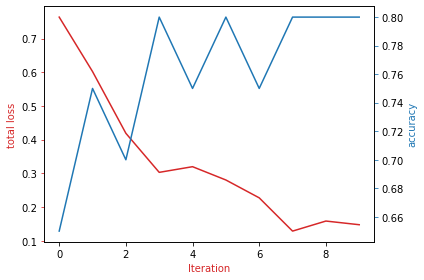

In [30]:
plot_stuff(loss_list,accuracy_list)

Load the model that performs best:  


In [31]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, n_classes)
model.load_state_dict(torch.load( "model.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## What's Next


You can also deploy your model via Web Application or Web App . This allows users to interact with your model like a website. They can upload the image with a user interface and view the results. Let's see how we can deploy a web app in CV Studio. In CV Studio, go to the use model section and select New Application. Fill out the window as follows,  giving  your model a name and selecting the Model in this project, select **TEST - 1-click Deploy your Model to Cloud (Code Engine)** and  select the model from the  training run as shown here: 

<p>
<img  src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-SkillsNetwork/images/Image_2021-05-20_at_8.04_AM.jpeg"  alt="popup" width="400" height="500">
</p>

Then once the window is filled out press the Create Application button and your model will begin deploying.

<p>
<img  src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-SkillsNetwork/images/Image_2021-05-20_at_8.07_AM.jpeg"  alt="popup" width="500" height="100">
</p>

Wait until the status changes from "deploying" to "ready". Once the status changes to ready, your application is ready for you to use!

<p>
<img  src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-SkillsNetwork/images/Image_2021-05-20_at_8.08_AM.jpeg"  alt="popup" width="500" height="100">
</p>

You can press the URL to go to your web application.

<p>
<img  src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-SkillsNetwork/images/Image_2021-05-20_at_3.12_PM.jpeg"  alt="popup" width="500" height="400">
</p>


## Authors


Joseph Santarcangelo,has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description      |
| ----------------- | ------- | ---------- | ----------------------- |
| 2021-05-25        | 0.3     | Yasmine    | Modifies Multiple Areas |
| 2021-05-25        | 0.3     | Kathy      | Modified Multple Areas. |
| 2021-03-08        | 0.2     | Joseph     | Modified Multiple Areas |
| 2021-02-01        | 0.1     | Joseph     | Modified Multiple Areas |


Copyright © 2021 IBM Corporation. All rights reserved.
